In [1]:
import pandas as pd
import numpy as np
import os
import string
import glob
import random

In [2]:
Dimen=1000
Ngram=3
alph={}

In [3]:
############### Item Memory ##################################
for data in string.ascii_lowercase:
    RandomIndexList = np.random.permutation(Dimen)
    RandomHV = np.ones(Dimen, dtype=np.int)
    RandomHV[RandomIndexList[0:Dimen//2]] = 1
    RandomHV[RandomIndexList[Dimen//2:Dimen]] = -1
    alph[data]=RandomHV
np.random.shuffle(alph['a'])
alph[' ']=alph['a'].copy()
np.random.shuffle(alph['a'])

C:\Users\mdasi\AppData\Local\Temp\ipykernel_21824\1319221806.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  RandomHV = np.ones(Dimen, dtype=np.int)


In [7]:
type(alph['a'])

numpy.ndarray

In [4]:
#########Loading data##################

LangLabels = ['bul', 'ces', 'dan', 'nld', 'deu', 'eng', 'est', 'fin', 'fra', 'ell', 'hun', 'ita',
              'lav', 'lit', 'pol', 'por', 'ron', 'slk', 'slv', 'spa', 'swe']
Traindata=[]
Trainlabel=[]
for i, Label in enumerate(LangLabels):
    FilePath = os.path.join('language','training_texts',"{}.txt".format(Label))
    with open(FilePath,'r', encoding='utf-8') as f:
        inputseq=f.read()
    senlist=inputseq.split('\n')
    for data in senlist:
        Traindata.append(data)
        Trainlabel.append(i)
print("{} sentences have been loaded for train".format(str(len(Traindata))))

210080 sentences have been loaded for train


In [5]:
ShortLangLabels = ['bg', 'cs', 'da', 'nl', 'de', 'en', 'et', 'fi', 'fr', 'el', 'hu', 'it', 'lv', 'lt', 'pl', 'pt', 'ro', 'sk', 'sl', 'es', 'sv']
Testdata=[]
Testlabel=[]
mp = dict()
for i,key in enumerate(ShortLangLabels):
    mp[key] = i
TestFilePathList = glob.glob(os.path.join("language", "testing_texts", "*.txt"))
for i, TestFilePath in enumerate(TestFilePathList):
    (_, TestFileName) = os.path.split(TestFilePath)
    if not mp.__contains__(TestFileName[0:2]):
        continue
    Label = mp[TestFileName[0:2]]
    with open(TestFilePath,'r',encoding='utf-8') as f:
        InputSequence = f.read()
    Testdata.append(InputSequence[:-1]) 
    Testlabel.append(Label)
print("{} sentences have been loaded for test.".format(str(len(Testdata))))

21000 sentences have been loaded for test.


In [42]:
K=21
IM = dict() 
AM = dict()
IAM = dict()
LangLabels = []
for key in range(K):
    AM[key] = np.zeros(Dimen)
    LangLabels.append(key)

def GenerateHV():
    RandomIndexList = np.random.permutation(Dimen)
    RandomHV = np.ones(Dimen, dtype=np.int)
    RandomHV[RandomIndexList[0:Dimen//2]] = 1
    RandomHV[RandomIndexList[Dimen//2:Dimen]] = -1
    return RandomHV

def CalculateCosineSimilarity(HV1, HV2):
    DotProduct = np.dot(HV1, HV2.T)
    Norm1 = np.linalg.norm(HV1)
    Norm2 = np.linalg.norm(HV2)
    CosineSimilarity = float(DotProduct) / (Norm1 * Norm2)
    return CosineSimilarity 

def LookupIM(Key):
    if not IM.__contains__(Key):
        IM[Key] = GenerateHV();
    return IM[Key]

def NGramEncoding(InputSequence):
    block = np.zeros([Ngram, Dimen])
    sumHV = np.zeros(Dimen)
    for i, Key in enumerate(InputSequence):
        block = np.roll(block, (1, 1), (0, 1))
        block[0] = LookupIM(Key)
        if i >= Ngram - 1:
            NGramHV = block[0]
            for j in range(1, Ngram):
                NGramHV = NGramHV * block[j]
            sumHV = sumHV + NGramHV
    return sumHV

def Binarization(HV):
    threshold = 0 
    for i in range(Dimen):
        if HV[i] == 0:
            HV[i] = random.randint(0, 1) * 2 - 1
        elif HV[i] > threshold:
            HV[i] = 1
        else:
            HV[i] = -1
    return HV


length = len(Traindata)
for i in range(length):
    Data = Traindata[i]
    Label = Trainlabel[i]
    tmp = NGramEncoding(Data)
    AM[Label] = AM[Label] + tmp
for Label in LangLabels:
    IAM[Label] = AM[Label]
    AM[Label] = Binarization(AM[Label])


C:\Users\mdasi\AppData\Local\Temp\ipykernel_19404\2882018037.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  RandomHV = np.ones(Dimen, dtype=np.int)


In [43]:
length = len(Testdata)
predict = []
for i in range(length):
    Data = Testdata[i]
    TestHV = Binarization(NGramEncoding(Data))
    maxAngle = -1
    predicLang = -1
    for j,LangLabel in enumerate(LangLabels):
        angle = CalculateCosineSimilarity(AM[LangLabel], TestHV)
        if angle > maxAngle:
            maxAngle = angle
            predicLang = LangLabel
    predict.append(predicLang)

In [44]:
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
print("Accuracy score: ",accuracy_score(Testlabel,predict))

Accuracy score:  0.9077619047619048


In [45]:
f1_macro=f1_score(Testlabel,predict, average='macro')
f1_micro=f1_score(Testlabel,predict, average='micro')
f1_weighted=f1_score(Testlabel,predict, average='weighted')
f1_none=f1_score(Testlabel,predict, average=None)
print("F1 score with macro average: ",f1_macro)
print("F1 score with micro average: ",f1_micro)
print("F1 score with weighted average: ",f1_weighted)
print("F1 score with no average: ",f1_none)

F1 score with macro average:  0.9073317860956979
F1 score with micro average:  0.9077619047619048
F1 score with weighted average:  0.907331786095698
F1 score with no average:  [0.92216163 0.73007712 0.89871465 0.91868345 0.94837093 0.95489103
 0.93087558 0.95742574 0.93710385 0.94559842 0.96307537 0.94117647
 0.91130258 0.90881459 0.93037336 0.91686689 0.9286066  0.72264631
 0.88077859 0.88934637 0.91707799]


Text(0.5, 155.72222222222217, 'Predicted')

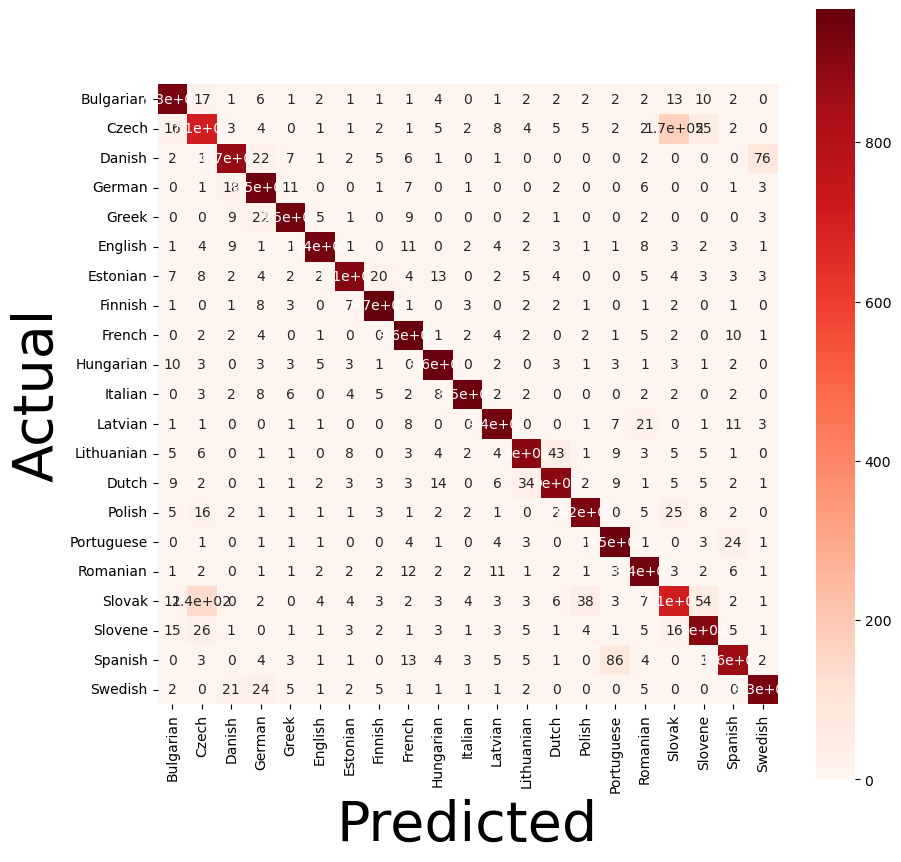

In [48]:
Labelss=['Bulgarian', 'Czech', 'Danish','German', 'Greek', 'English', 'Estonian', 'Finnish', 'French', 'Hungarian', 'Italian', 'Latvian',
         'Lithuanian', 'Dutch','Polish', 'Portuguese', 'Romanian', 'Slovak', 'Slovene', 'Spanish', 'Swedish']
cm = confusion_matrix(Testlabel,predict)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, cmap=plt.cm.Reds, annot=True, square=True, xticklabels=Labelss, yticklabels=Labelss)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)